In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Picked up _JAVA_OPTIONS: -Xms1024M -Xmx6144M251-b08, mixed mode)
  Starting server from e:\documents\university\timeseries\venv\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\babar\AppData\Local\Temp\tmpm1rsz501
  JVM stdout: C:\Users\babar\AppData\Local\Temp\tmpm1rsz501\h2o_babar_started_from_python.out
  JVM stderr: C:\Users\babar\AppData\Local\Temp\tmpm1rsz501\h2o_babar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_babar_n045b7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.333 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [107]:
# Load data from CSV
df = pd.read_csv('TOTALNSA.csv', parse_dates=True, index_col='DATE')
df.index.freq = "MS"

In [108]:
df.tail()

,TOTALNSA
DATE,
2019-08-01,1685.339
2019-09-01,1315.678
2019-10-01,1380.174
2019-11-01,1438.444
2019-12-01,1558.430


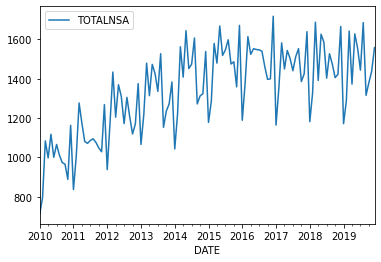

In [109]:
df.plot()

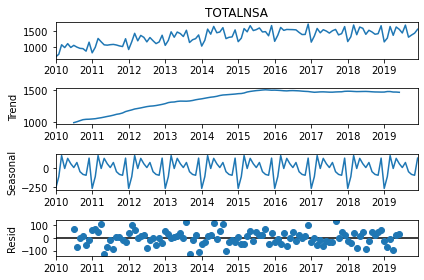

In [110]:
result_sd = seasonal_decompose(df.TOTALNSA)
result_sd.plot();

In [111]:
# add trend to variables
df1=df.copy()
df1['trend'] = result_sd.trend
df1.tail()

,TOTALNSA,trend
DATE,,
2019-08-01,1685.339,NaN
2019-09-01,1315.678,NaN
2019-10-01,1380.174,NaN
2019-11-01,1438.444,NaN
2019-12-01,1558.430,NaN


In [112]:
# add previous value to variables
df1['lag1'] = df1.TOTALNSA.shift(1)
df1.dropna(inplace=True)
df1.tail()

,TOTALNSA,trend,lag1
DATE,,,
2019-02-01,1288.278,1473.112208,1171.495
2019-03-01,1642.746,1473.054042,1288.278
2019-04-01,1372.696,1465.343500,1642.746
2019-05-01,1628.074,1464.947292,1372.696
2019-06-01,1554.747,1461.145167,1628.074


In [113]:
# add seasonality 12 to variables
df1['lag12'] = df1.TOTALNSA.shift(12)
df1.dropna(inplace=True)
df1.tail()

,TOTALNSA,trend,lag1,lag12
DATE,,,,
2019-02-01,1288.278,1473.112208,1171.495,1328.140
2019-03-01,1642.746,1473.054042,1288.278,1687.609
2019-04-01,1372.696,1465.343500,1642.746,1391.226
2019-05-01,1628.074,1464.947292,1372.696,1626.484
2019-06-01,1554.747,1461.145167,1628.074,1586.664


In [114]:
# add diff to variables
df1['d1'] = df1.TOTALNSA.diff(1)
df1.dropna(inplace=True)
df1.tail()

,TOTALNSA,trend,lag1,lag12,d1
DATE,,,,,
2019-02-01,1288.278,1473.112208,1171.495,1328.140,116.783
2019-03-01,1642.746,1473.054042,1288.278,1687.609,354.468
2019-04-01,1372.696,1465.343500,1642.746,1391.226,-270.050
2019-05-01,1628.074,1464.947292,1372.696,1626.484,255.378
2019-06-01,1554.747,1461.145167,1628.074,1586.664,-73.327


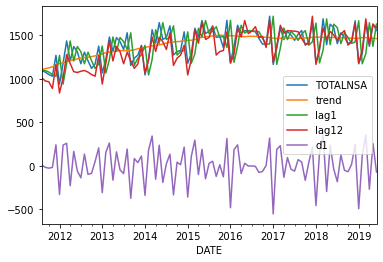

In [115]:
df1.plot()

In [116]:
train=h2o.H2OFrame(df1.iloc[:-12])
test=h2o.H2OFrame(df1.iloc[-12:])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [117]:
x=['lag12', 'lag1', 'trend', 'd1']
y='TOTALNSA'

In [118]:
model = H2ORandomForestEstimator(ntrees=100, max_depth=30, nfolds=15)
model.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [119]:
performance = model.model_performance(test_data=test)
print(performance)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 1811.9511771167126
RMSE: 42.56701982893227
MAE: 38.775986226399745
RMSLE: 0.029440548464803748
Mean Residual Deviance: 1811.9511771167126



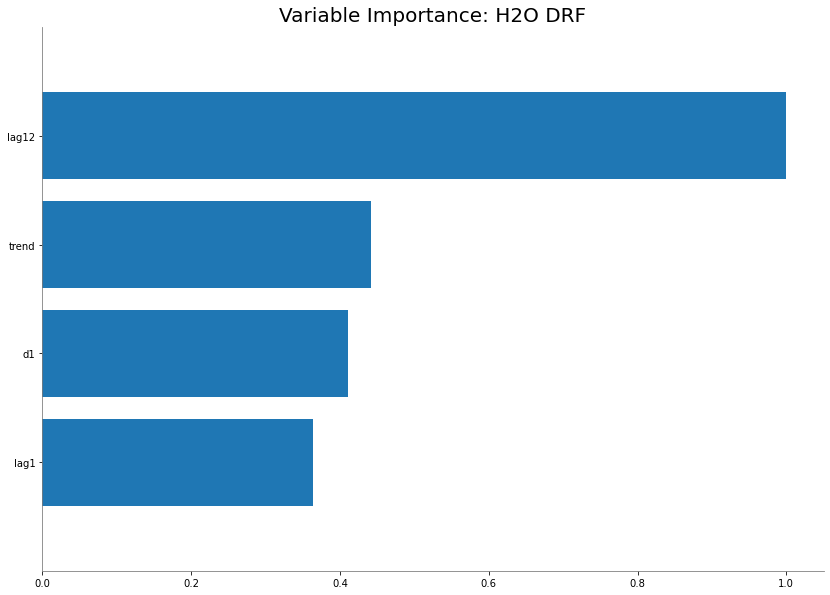

In [120]:
model.varimp_plot()

In [121]:
predictions = model.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [122]:
predictions_df = predictions.as_data_frame()

In [124]:
predictions_df.index = dates_new = pd.date_range(str(df1.index[-1]), periods=12, freq='MS')

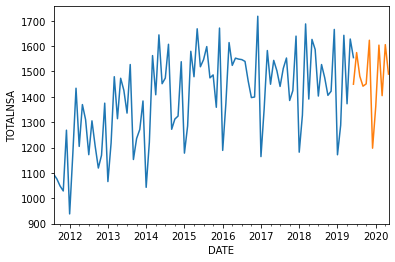

In [127]:
ax = df1.TOTALNSA.plot()
predictions_df.predict.plot()
plt.ylabel("TOTALNSA")
plt.show()